In [2]:
import numpy as np
from matplotlib import pyplot as plt


# Get names of columns
data=np.genfromtxt('galaxyquasar.csv', delimiter=',', names=True, usecols=(0,1,2,3,4,6))
names = data.dtype.names
print(names)

#Get data without last column (z-error)
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)
print(data.shape)
print(data[0])

#Get true labels
labels = np.genfromtxt('galaxyquasar.csv', delimiter=',', skip_header=1, usecols=(5), dtype=str)
print(labels.shape)
print(labels[0:10])

('u', 'g', 'r', 'i', 'z', 'z1')
(50000, 6)
[18.97213   18.53676   18.5828    18.34936   18.29215    0.5228189]
(50000,)
['QSO' 'GALAXY' 'GALAXY' 'GALAXY' 'QSO' 'GALAXY' 'GALAXY' 'QSO' 'GALAXY'
 'GALAXY']


In [3]:
ug_set = data[:,0] - data[:, 1]
gr_set = data[:, 1] - data[:, 2]
ri_set = data[:, 2] - data[:, 3]
iz_set = data[:, 3] - data[:, 4]
labels = np.array([1 if label == 'QSO' else 0 for label in labels])

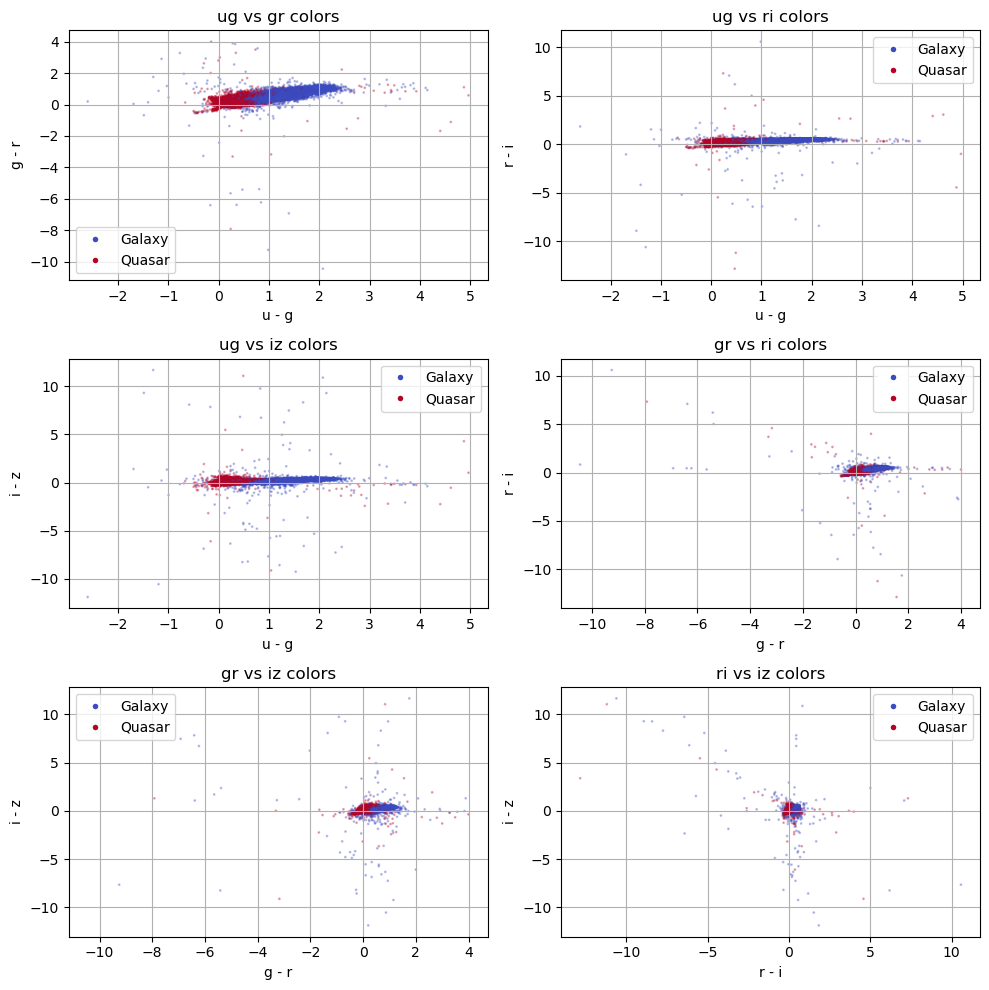

In [4]:
from matplotlib.lines import Line2D

fig1, ax1 = plt.subplots(3,2, figsize=(10, 10))
# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Galaxy', markerfacecolor=plt.cm.coolwarm(0.), markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Quasar', markerfacecolor=plt.cm.coolwarm(1.), markersize=5)
]

# Add the same legend to all axes
for ax in ax1.flat:
    ax.legend(handles=legend_elements)
    ax.grid()

ax1[0][0].scatter(ug_set, gr_set, c=labels, cmap='coolwarm', s=1, alpha=0.3)
ax1[0][0].set_xlabel('u - g')
ax1[0][0].set_ylabel('g - r')
ax1[0][0].set_title('ug vs gr colors')

ax1[0][1].scatter(ug_set, ri_set, c=labels, cmap='coolwarm', s=1, alpha=0.3)
ax1[0][1].set_xlabel('u - g')
ax1[0][1].set_ylabel('r - i')
ax1[0][1].set_title('ug vs ri colors')

ax1[1][0].scatter(ug_set, iz_set, c=labels, cmap='coolwarm', s=1, alpha=0.3)
ax1[1][0].set_xlabel('u - g')
ax1[1][0].set_ylabel('i - z')
ax1[1][0].set_title('ug vs iz colors')

ax1[1][1].scatter(gr_set, ri_set, c=labels, cmap='coolwarm', s=1, alpha=0.3)
ax1[1][1].set_xlabel('g - r')
ax1[1][1].set_ylabel('r - i')
ax1[1][1].set_title('gr vs ri colors')

ax1[2][0].scatter(gr_set, iz_set, c=labels, cmap='coolwarm', s=1, alpha=0.3)
ax1[2][0].set_xlabel('g - r')
ax1[2][0].set_ylabel('i - z')
ax1[2][0].set_title('gr vs iz colors')

ax1[2][1].scatter(ri_set, iz_set, c=labels, cmap='coolwarm', s=1, alpha=0.3)
ax1[2][1].set_xlabel('r - i')
ax1[2][1].set_ylabel('i - z')
ax1[2][1].set_title('ri vs iz colors')

fig1.subplots_adjust(hspace=0.8)
plt.tight_layout()


Confusion Matrix for threshold = 0.5:
 [[8422  150]
 [ 107 1321]]
Completeness for threshold = 0.5: 0.9250700280112045
Contamination for threshold = 0.5: 0.10197144799456152
(339,)
Threshold limits to have both completeness and precision over 0.9: t_min = 0.51251, t_max = 0.85085
Best threshold: 0.51251
[0.92436975]


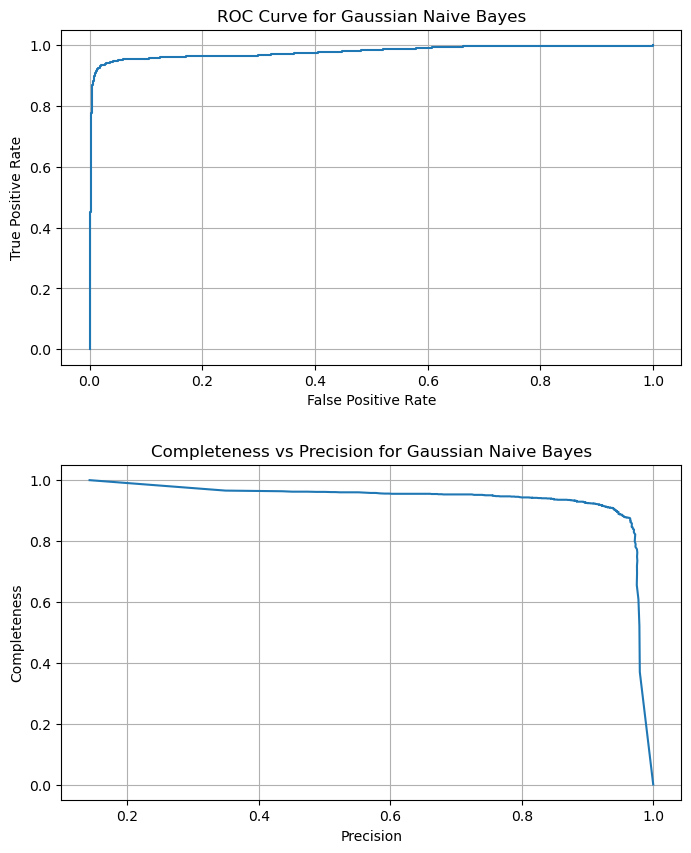

In [7]:
#CLASSIFICATION BY GAUSSIAN NAIVE BAYES

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

#Starting classification with U-G and G-R colors

X_tot = np.column_stack((ug_set,gr_set,ri_set,iz_set))
X = X_tot[:,:2]
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

clf = GaussianNB()
clf.fit(X_train, y_train)

# Predicting the labels for the test set with default threshold:0.5
y_pred = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
comp, cont = completeness_contamination(y_pred, y_test)
print("Confusion Matrix for threshold = 0.5:\n", conf_mat)
print("Completeness for threshold = 0.5:", comp)
print("Contamination for threshold = 0.5:", cont)

#Computing ROC curve varying the threshold to choose the best one
thresholds = np.linspace(0, 1, 1000)
y_prob = clf.predict_proba(X_test)[:, 1]
fpr_gnb, tpr_gnb, thresh_gnb = roc_curve(y_test, y_prob)
fig2,ax2 = plt.subplots(2,1, figsize=(8, 10))
ax2[0].plot(fpr_gnb, tpr_gnb, label='GNB')
ax2[0].set_xlabel('False Positive Rate')
ax2[0].set_ylabel('True Positive Rate')
ax2[0].set_title('ROC Curve for Gaussian Naive Bayes')
ax2[0].grid()

comp_gnb, cont_gnb = np.zeros(len(thresholds)), np.zeros(len(thresholds))
for n,t in zip(np.arange(len(thresholds)), thresholds):
    y_pred = np.zeros(len(y_test))
    y_pred[clf.predict_proba(X_test)[:, 1] > t] = 1
    comp_gnb[n], cont_gnb[n] = completeness_contamination(y_pred, y_test)

ax2[1].plot(1-cont_gnb, comp_gnb, label='GNB')
ax2[1].set_xlabel('Precision')
ax2[1].set_ylabel('Completeness')
ax2[1].set_title('Completeness vs Precision for Gaussian Naive Bayes')
ax2[1].grid()
fig2.subplots_adjust(hspace=0.3)

acc_thresh = thresholds[(1-cont_gnb>0.9)&(comp_gnb>0.9)]
print(acc_thresh.shape)
print(f"Threshold limits to have both completeness and precision over 0.9: t_min = {acc_thresh.min():.5f}, t_max = {acc_thresh.max():.5f}")
#Best threshold decided as the one with maximal completeness with precision over 0.9
best_thresh = acc_thresh[comp_gnb.argmax()]
print(f"Best threshold: {best_thresh:.5f}")
print(comp_gnb[thresholds == best_thresh])



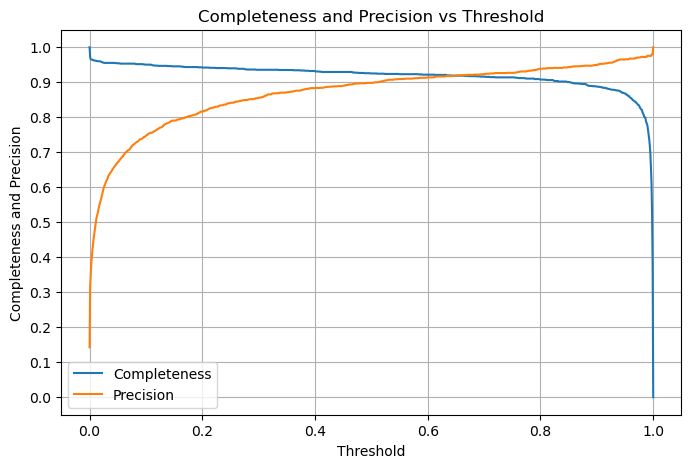

In [26]:
fig3,ax3 = plt.subplots(figsize=(8, 5))
ax3.plot(thresholds, comp_gnb, label='Completeness')
ax3.plot(thresholds, 1-cont_gnb, label='Precision')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Completeness and Precision')
ax3.set_title('Completeness and Precision vs Threshold')
ax3.set_yticks(np.arange(0, 1.1, 0.1))
ax3.legend()
ax3.grid()


Text(0.5, 1.0, 'Classification Contour with Gaussian Naive Bayes and threshold = 0.51')

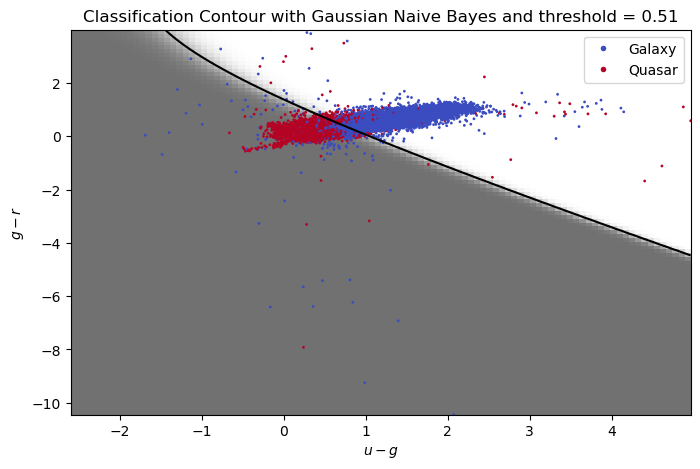

In [9]:
#Visualizing contour classification in u-g map with best_thresh

fig4, ax4 = plt.subplots(figsize=(8, 5))
ax4.legend(handles=legend_elements)
xlim =  X[:,0].min(), X[:,0].max()
ylim = X[:,1].min(), X[:,1].max()
xx, yy = np.meshgrid(np.linspace(xlim[0],xlim[1], 100),np.linspace(ylim[0], ylim[1], 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
im = ax4.scatter(ug_set, gr_set, c=labels, s=4, linewidths=0, cmap=plt.cm.coolwarm, zorder=2)
im.set_clim(0, 1)
im = ax4.imshow(Z, origin='lower', aspect='auto',cmap=plt.cm.binary, zorder=1, extent=xlim + ylim)
im.set_clim(0, 1.8)
ax4.contour(xx, yy, Z, [1-best_thresh], colors='k')
ax4.set_xlim(xlim)
ax4.set_ylim(ylim)
ax4.set_xlabel('$u-g$')
ax4.set_ylabel('$g-r$')
ax4.set_title('Classification Contour with Gaussian Naive Bayes and threshold = {:.2f}'.format(best_thresh))

At threshold = 0.5 with 2 components
Completeness: 0.917   Precision: 0.912

At threshold = 0.5 with 3 components
Completeness: 0.931   Precision: 0.924

At threshold = 0.5 with 4 components
Completeness: 0.925   Precision: 0.938

At threshold = 0.5 with 5 components
Completeness: 0.923   Precision: 0.945

At threshold = 0.5 with 6 components
Completeness: 0.930   Precision: 0.944

At threshold = 0.5 with 7 components
Completeness: 0.932   Precision: 0.943

At threshold = 0.5 with 8 components
Completeness: 0.931   Precision: 0.944



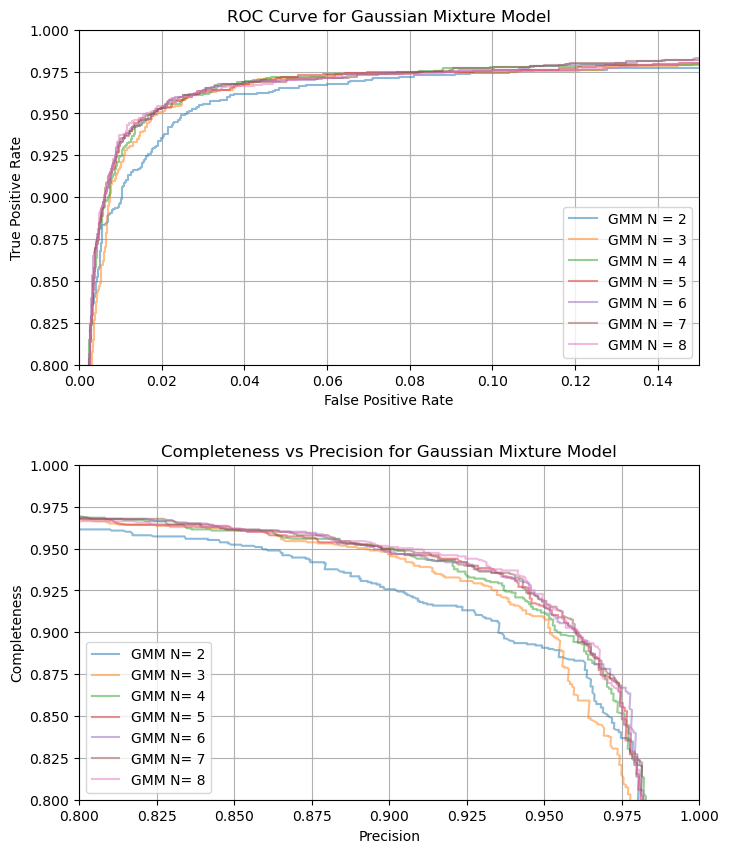

In [13]:
#REPEATING CLASSIFICATION WITH GMM BAYESIAN CLASSIFIER

from astroML.classification import GMMBayes
ncomp = np.arange(2,9)
fig5, ax5 = plt.subplots(2, 1, figsize=(8, 10))

clf_n = []

for nc in ncomp:
    clf = GMMBayes(nc,covariance_type='full', tol=1e-4, random_state=42)
    clf.fit(X_train, y_train)
    clf_n.append(clf)
    y_prob = clf.predict_proba(X_test)[:, 1]
    fpr_gnb, tpr_gnb, thresh_gnb = roc_curve(y_test, y_prob)

   
# Plotting ROC curve
    ax5[0].plot(fpr_gnb, tpr_gnb, label=f'GMM N = {nc}', alpha=0.5)


#Plotting completeness vs precision
    comp_gmm, cont_gmm = np.zeros(len(thresholds)), np.zeros(len(thresholds))
    for n,t in zip(np.arange(len(thresholds)), thresholds):
        y_pred = np.zeros(len(y_test))
        y_pred[clf.predict_proba(X_test)[:, 1] > t] = 1
        comp_gmm[n], cont_gmm[n] = completeness_contamination(y_pred, y_test)
    ax5[1].plot(1-cont_gmm, comp_gmm, label=f'GMM N= {nc}', alpha=0.5)
    idx_05 = np.argmin(np.abs(thresholds - 0.5))
    print(f"At threshold = 0.5 with {nc} components\nCompleteness: {comp_gmm[idx_05]:.3f}   Precision: {1-cont_gmm[idx_05]:.3f}\n")



ax5[0].set_xlabel('False Positive Rate')
ax5[0].set_ylabel('True Positive Rate')
ax5[0].set_xlim([0, 0.15])
ax5[0].set_ylim([0.8, 1.0])
ax5[0].set_title('ROC Curve for Gaussian Mixture Model')
ax5[0].legend()
ax5[0].grid()

ax5[1].set_xlabel('Precision')
ax5[1].set_ylabel('Completeness')
ax5[1].set_xlim([0.8, 1])
ax5[1].set_ylim([0.8, 1.0])
ax5[1].set_title('Completeness vs Precision for Gaussian Mixture Model')
ax5[1].legend()
ax5[1].grid()
fig5.subplots_adjust(hspace=0.3)


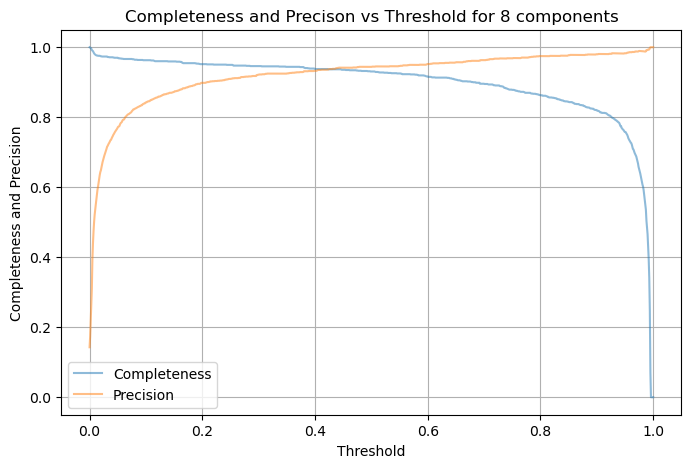

In [ ]:
#Choosing the best GMM model based on completeness and contamination

fig6,ax6 = plt.subplots(figsize=(8, 5))
comp_gmm, cont_gmm = np.zeros(len(thresholds)), np.zeros(len(thresholds))
for n,t in zip(np.arange(len(thresholds)), thresholds):
    y_pred = np.zeros(len(y_test))
    y_pred[clf_n[6].predict_proba(X_test)[:, 1] > t] = 1
    comp_gmm[n], cont_gmm[n] = completeness_contamination(y_pred, y_test)
ax6.plot(thresholds, comp_gmm, alpha = 0.5, label=f'Completeness')
ax6.plot(thresholds, 1-cont_gmm, alpha = 0.5, label=f'Precision')
ax6.set_xlabel('Threshold')
ax6.set_ylabel('Completeness and Precision')
ax6.set_title('Completeness and Precison vs Threshold for 8 components')
ax6.set_yticks(np.arange(0, 1.1, 0.1))
ax6.legend()
ax6.grid()


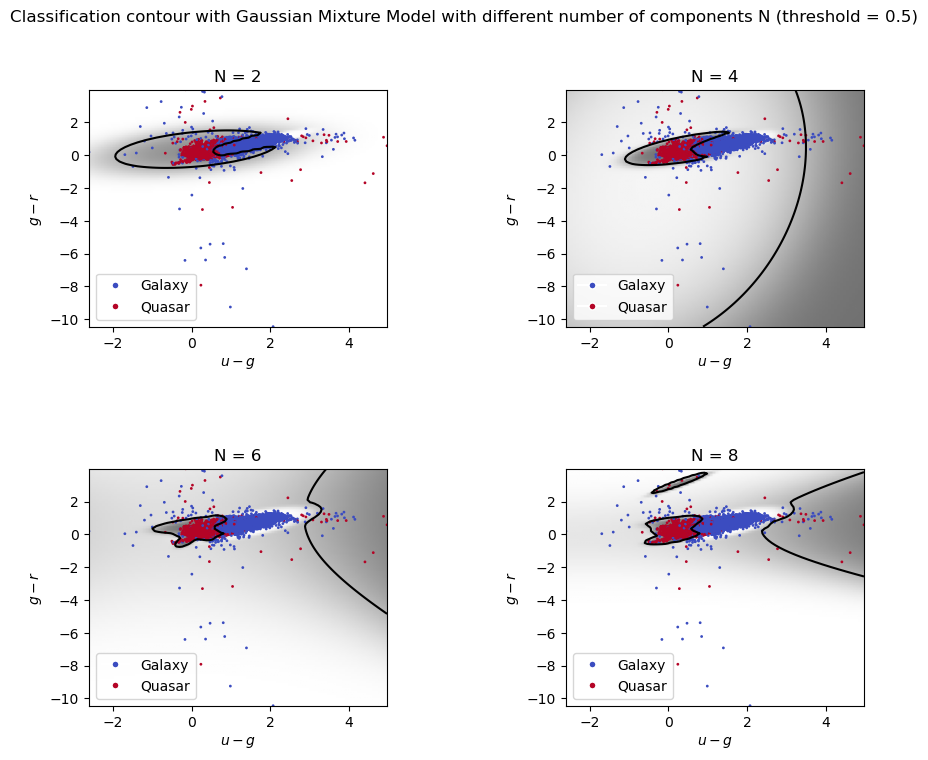

In [9]:
fig7, ax7 = plt.subplots(2,2,figsize=(10, 8))
for ax, clf in zip(ax7.flatten(), [clf_n[0], clf_n[2], clf_n[4], clf_n[6]]):
    ax.legend(handles=legend_elements)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    im = ax.scatter(ug_set, gr_set, c=labels, s=4, linewidths=0, cmap=plt.cm.coolwarm, zorder=2)
    im.set_clim(0, 1)
    im = ax.imshow(Z, origin='lower', aspect='auto', cmap=plt.cm.binary, zorder=1, extent=xlim + ylim)
    im.set_clim(0, 1.8)
    ax.contour(xx, yy, Z, [0.5], colors='k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$u-g$')
    ax.set_ylabel('$g-r$')
    ax.set_title(f'N = {clf_n.index(clf) + 2}')
fig7.suptitle('Classification contour with Gaussian Mixture Model with different number of components N (threshold = 0.5)')
fig7.subplots_adjust(hspace = 0.6, wspace = 0.6)

At threshold = 0.5 with 1 nearest neighbors
Completeness: 0.901   Precision: 0.901

At threshold = 0.5 with 2 nearest neighbors
Completeness: 0.941   Precision: 0.858

At threshold = 0.5 with 3 nearest neighbors
Completeness: 0.922   Precision: 0.931

At threshold = 0.5 with 4 nearest neighbors
Completeness: 0.936   Precision: 0.919

At threshold = 0.5 with 5 nearest neighbors
Completeness: 0.928   Precision: 0.939

At threshold = 0.5 with 6 nearest neighbors
Completeness: 0.933   Precision: 0.928



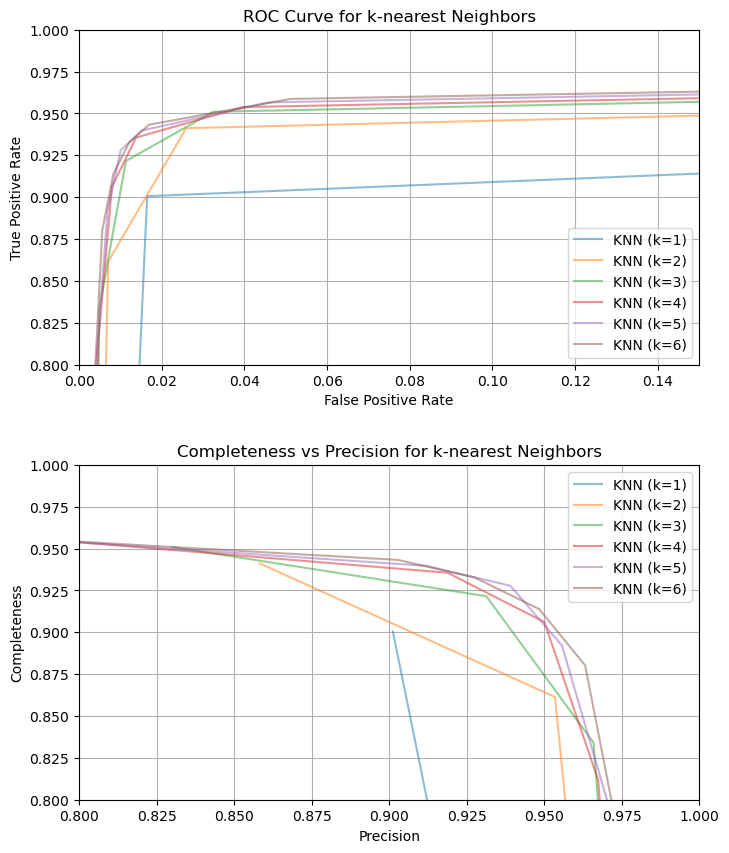

In [11]:
#LASTLY, CLASSIFICATION BY K-NEAREST NEIGHBOURS
from sklearn.neighbors import KNeighborsClassifier

fig8, ax8 = plt.subplots(2, 1, figsize=(8, 10))

k_range = np.arange(1,7)
clf_k = []

for k in k_range:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    clf_k.append(clf)
    y_prob = clf.predict_proba(X_test)[:, 1]
    fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, y_prob)
    ax8[0].plot(fpr_knn, tpr_knn, label=f'KNN (k={k})', alpha=0.5)

    comp_knn, cont_knn = np.zeros(len(thresholds)), np.zeros(len(thresholds))
    for n,t in zip(np.arange(len(thresholds)), thresholds):
        y_pred = np.zeros(len(y_test))
        y_pred[clf.predict_proba(X_test)[:, 1] > t] = 1
        comp_knn[n], cont_knn[n] = completeness_contamination(y_pred, y_test)
    ax8[1].plot(1-cont_knn, comp_knn, label=f'KNN (k={k})', alpha=0.5)
    idx_05 = np.argmin(np.abs(thresholds - 0.5))
    print(f"At threshold = 0.5 with {k} nearest neighbors\nCompleteness: {comp_knn[idx_05]:.3f}   Precision: {1-cont_knn[idx_05]:.3f}\n")

ax8[0].set_xlabel('False Positive Rate')
ax8[0].set_ylabel('True Positive Rate')
ax8[0].set_xlim([0, 0.15])
ax8[0].set_ylim([0.8, 1.0])
ax8[0].set_title('ROC Curve for k-nearest Neighbors')
ax8[0].legend()
ax8[0].grid()

ax8[1].set_xlabel('Precision')
ax8[1].set_ylabel('Completeness')
ax8[1].set_xlim([0.8, 1])
ax8[1].set_ylim([0.8, 1.0])
ax8[1].set_title('Completeness vs Precision for k-nearest Neighbors')
ax8[1].legend()
ax8[1].grid()
fig8.subplots_adjust(hspace=0.3)

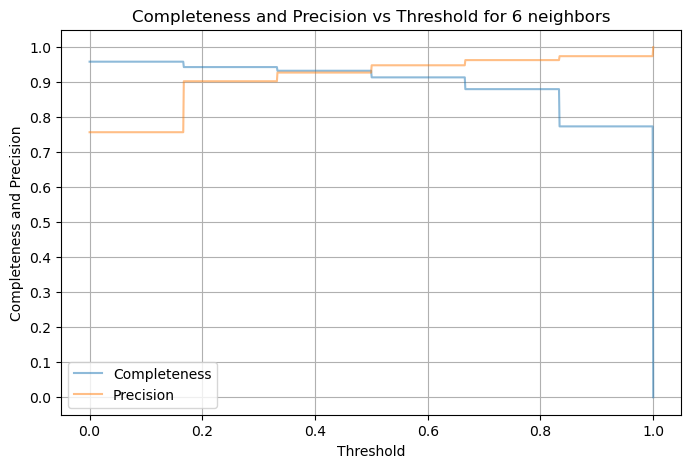

In [29]:
fig9,ax9 = plt.subplots(figsize=(8, 5))
comp_knn, cont_knn = np.zeros(len(thresholds)), np.zeros(len(thresholds))
for n,t in zip(np.arange(len(thresholds)), thresholds):
    y_pred = np.zeros(len(y_test))
    y_pred[clf_k[5].predict_proba(X_test)[:, 1] > t] = 1
    comp_knn[n], cont_knn[n] = completeness_contamination(y_pred, y_test)
ax9.plot(thresholds, comp_knn, alpha = 0.5, label='Completeness')
ax9.plot(thresholds, 1-cont_knn, alpha = 0.5, label='Precision')
ax9.set_xlabel('Threshold')
ax9.set_ylabel('Completeness and Precision')
ax9.set_yticks(np.arange(0, 1.1, 0.1))
ax9.legend()
ax9.set_title('Completeness and Precision vs Threshold for 6 neighbors')
ax9.grid()

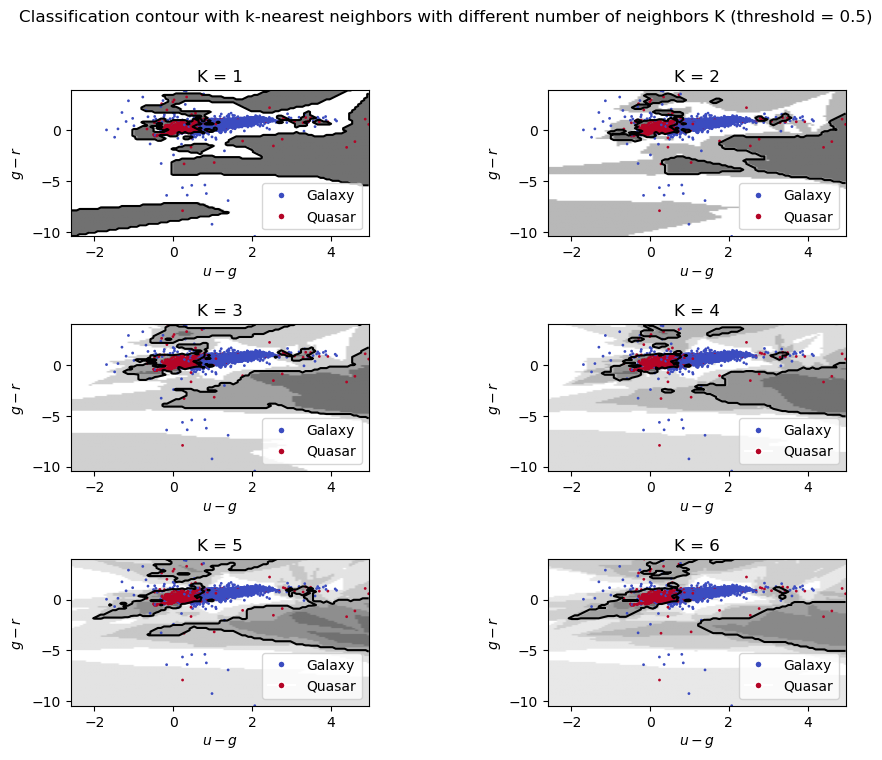

In [12]:
fig10, ax10 = plt.subplots(3,2,figsize=(10, 8))
for ax, clf in zip(ax10.flatten(), clf_k):
    ax.legend(handles=legend_elements)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    im = ax.scatter(ug_set, gr_set, c=labels, s=4, linewidths=0, cmap=plt.cm.coolwarm, zorder=2)
    im.set_clim(0, 1)
    im = ax.imshow(Z, origin='lower', aspect='auto', cmap=plt.cm.binary, zorder=1, extent=xlim + ylim)
    im.set_clim(0, 1.8)
    ax.contour(xx, yy, Z, [0.5], colors='k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$u-g$')
    ax.set_ylabel('$g-r$')
    ax.set_title(f'K = {clf_k.index(clf) +1}')
fig10.suptitle('Classification contour with k-nearest neighbors with different number of neighbors K (threshold = 0.5)')
fig10.subplots_adjust(hspace = 0.6, wspace = 0.6)